# IEX Trading

The Investors Exchange, [IEX](https://iextrading.com/), is a transparent stock exchange that discourages high-frequency trading and makes historical trading data [publicly available](https://iextrading.com/trading/market-data/#hist-download). The data is offered in the form of daily [pcap](https://en.wikipedia.org/wiki/Pcap) files where each single packet corresponds to a stock trade.

Even with this specialized pcap file format, these daily records can exceed a gigabyte in size on a given day. In this notebook, we will
develop a dashboard that will allow us to explore every single trade that happened in a day, including the associated metadata. To visualize all this data at once both rapidly and interactively, we will use [datashader](https://datashader.org/) via the [HoloViewsAPI](http://holoviews.org/user_guide/Large_Data.html).

## Loading the data

The [IEX stock data](https://iextrading.com/trading/market-data/#hist-download) is saved in two formats of pcap file called [TOPS](https://iextrading.com/docs/IEX%20TOPS%20Specification.pdf) and [DEEP](https://iextrading.com/docs/IEX%20DEEP%20Specification.pdf). These formats are complex enough to make it non trivial to parse the trades with standard packet loading tools. For this reason, the trades for Monday 21st of October 2019 are supplied as a CSV file that has been generated from the original pcap file using the [IEXTools](https://pypi.org/project/IEXTools/) library.

![image](./thumbnails/iex_trading_thumbnail.png)

In [ ]:
import datetime
import pandas as pd

df = pd.read_csv('./data/IEX_2019-10-21.csv')

We can now look at the head of this DataFrame to see its structure:

In [12]:
df.head()

,symbol,size,price,timestamp
0,VICI,100,23.350,2019-10-21 13:47:12.287461181
1,ERIC,100,9.085,2019-10-21 10:42:49.356416435
2,VER,2000,9.905,2019-10-21 13:00:16.837804490
3,SWK,100,149.840,2019-10-21 14:06:46.720249154
4,PE,100,15.515,2019-10-21 13:14:39.015867086


Each row above corresponds to a stock trade where `price` indicates the stock price, the `size` indicates the number of stocks in the trade, and the `symbol` specifies which stock was traded. Every trade also has a timestamp specified in nanoseconds.

Note that multiple trades can occur on the same timestamp.

## Visualizing trade with `Spikes`

We can now load HoloViews with the Bokeh plotting extension to start visualizing some of this data:

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
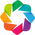

In [13]:
import holoviews as hv
from bokeh.models import HoverTool
from holoviews.operation.datashader import spikes_aggregate
hv.extension('bokeh')

One way to visualize events that occur over time is to use the [Spikes](http://holoviews.org/reference/elements/bokeh/Spikes.html#bokeh-gallery-spikes)
element. Here we look at the first hundred spikes in this dataframe:

In [14]:
#hv.config.image_rtol = 10e-3 # Fixes datetime issue at high zoom level

df['timestamp'] = pd.to_datetime(df['timestamp'])
hv.Spikes(df.head(100), ['timestamp'],
          ['symbol', 'size', 'price']).opts(xrotation=90,  tools=['hover'],
                                            spike_length=1, position=0)

:Spikes   [timestamp]   (symbol,size,price)

As in the dataframe tables shown above, the timestamps are expressed as integers counting the nanoseconds since Unix epoch (UTC). While many domains may use integers as their time axis (e.g., CPU cycle for processor events), in this case, we would like to recover the timestamp as a date.

We will do this in two steps: 
1. We map the integers to `datetime64[ns]` to get `datetime` objects.
2. We subtract 4 hours to go from UTC to the local time at the exchange (located in New Jersy):


In [15]:
df.timestamp = df.timestamp.astype('datetime64[ns]')
df.timestamp -= datetime.timedelta(hours=4)

Here every line corresponds to a trade where the position along the x-axis indicates the time at which that trade occurred (the `timestamp` in nanoseconds). If you hover over the spikes above, you can view all the timestamp values for the trades underneath the cursor as well as their corresponding stock symbols.

Using Bokeh we can only visualize a small number of trades effectively, but using datashader we can visualize all 1.2 million trades available:


In [16]:
spikes = hv.Spikes(df, ['timestamp'], ['symbol', 'size', 'price'])
rasterized = spikes_aggregate(spikes,
                              aggregator='count', spike_length=1).opts(
                                  width=600, colorbar=True, cmap='blues',
                                  yaxis=None, xrotation=90,
                                  default_tools=['xwheel_zoom', 'xpan', 'xbox_zoom'])
rasterized

:DynamicMap   []
   :Image   [timestamp,y]   (timestamp_y Count)

Using the `count` aggregator, we can see the density of trades over time colormapped such that white indicates the highest trade density and black indicates a lack of trades at that time. In the [next notebook](./IEX_stocks.ipynb) we will aggregate over the `'size'` column to visualize a more useful metric, namely the trade volume.

We use `spike_length` plot option to give all the spikes a fixed height regardless of any value dimensions specified. The `Spikes` element also supports variable heights according to a value dimension as seen [on the reference page](https://holoviews.org/reference/elements/bokeh/Spikes.html#bokeh-gallery-spikes).

Note that the above plot is interactive: when you zoom in, datashader will recompute and update the visualization accordingly. When zoomed out, you will notice that trade volume goes up at the end of the day - these are all the trades being made at the last minute before the exchange closes for that day!

## Exploring the IEX trade metadata interactively

Using Bokeh, we can view individual trade metadata using the hover tool for a small number of trades and using datashader, we can visualize a very large number of trades. Now we can investigate whether it is possible to have the best of both worlds.

When zoomed out, viewing all the trades for an entire day, hover information wouldn't be particularly useful. A single pixel would represent the accumulation of many trades across many neighboring timestamps which means hovering would not be able to target any specific trades effectively.

Instead, what we can do is use datashader to visualize trades at all zoom levels and use Bokeh to make hover information visible once sufficiently zoomed in to point to individual trades. This avoids the problem of pushing the entire dataset to your web browser and makes Bokeh's hover feature available when it is most useful.

### Using HoloViews to build custom interactivity

Enabling Bokeh hover information at a specific zoom level is not the best approach as different days will have different trade volumes and no fixed window will be appropriate for all datasets.

Instead, what we want to do is to always show hover information for as many trades as Bokeh can effectively handle. In other words, we want to count how many trades can be handled by the browser and use that number to decide whether or not hover information should be made available.

Counting trades is as simple as counting the number of rows in the pandas DataFrame that datashader is rendering for a given zoom level. We don't need to hook in the HoloViews datashader operation to achieve this: instead, we can disable the normal interactive behavior and rebuild it using HoloViews streams and the `apply` method.

Before this approach is demonstrated, we will want to define a [custom Bokeh hover tool](https://docs.bokeh.org/en/latest/docs/user_guide/tools.html#hovertool) to format our datetime timestamps nicely:


In [17]:
hover = HoverTool(tooltips=[
    ('Symbol', '@symbol'),
    ('Size', '@size'),
    ('Price', '@price'),
    ('Timestamp', '@timestamp{%F %H:%M %Ss %3Nms}')],
    formatters={'timestamp': 'datetime'})

#holoviews a way to do the hovertool

Next we declare a `RangeX` stream to get the plot range from Bokeh from our spikes object:

In [18]:
range_stream = hv.streams.RangeX(source=spikes)

Using this stream, we can write a callback that uses the supplied x-ranges to do the following:

1. First, it slices all the spikes across the whole dataset to those visible in the current viewport (`spikes[pd.to_datetime(low):pd.to_datetime(high)]`).
2. Next, it checks if there are fewer than 600 spikes. If so, it returns this sliced set of spikes; otherwise, it returns `ranged.iloc[:0]`, which is a `Spikes` object containing zero spikes.
3. We make sure these spikes are plotted with a length of one and make them invisible (we only want the associated hover informatin).


In [19]:
def xrange_filter(spikes, x_range):
    low, high = (None, None) if x_range is None else x_range
    ranged = spikes[pd.to_datetime(low):pd.to_datetime(high)]
    return (ranged if len(ranged) < 600 else ranged.iloc[:0]).opts(spike_length=1, alpha=0)

Finally, we can combine our `range_stream` with this callback using the
`apply` method on spikes. This creates a `DynamicMap` that will offer
the hover information for 600 or fewer spikes once sufficiently zoomed
in. The only thing left to do is to overlay this on top of the
interactive, zoomable rasterization generated by the datashader
operation:

In [20]:
filtered = spikes.apply(xrange_filter, streams=[range_stream])
hover_filtered =  filtered.opts(tools=[hover])
rasterized * hover_filtered

:DynamicMap   []
   :Overlay
      .Image.I  :Image   [timestamp,y]   (timestamp_y Count)
      .Spikes.I :Spikes   [timestamp]   (symbol,size,price)

Try zooming into the last 500 millisecond region before the exchange closes to see the last few stock symbols that were traded on that day.

## Next steps

This notebook illustrates how a large number of events (1.2 million) can be visualized interactively with datashader and how we can inspect the data for individual events by zooming in and using the hover tool. Visualizing all the data at once in this way allows you to see the overall structure of the data and identify any particularities in it. For instance, the increase in trading volume at the end of the day is immediately obvious, and by zooming in, it is possible to identify a handful of trades that occur after 4pm after the bulk of trading has ceased.

What this visualization fails to offer is any way to identify the trading patterns of individual stocks out of the entire volume of trades. The hover tool only activates when zoomed in, and there is no suitable method for partitioning out the trading times by stock. The next notebook will extend the approach developed here to analyze the most traded stocks on this day.
